In [293]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1 : MLP

## 1. Dataset Loading

In [294]:
df = pd.read_csv('matches.csv')
df = df.drop(columns=["Unnamed: 0"])
df

,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,1,0,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,1,0,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,7,0,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,Italy,4,2,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,Portugal,2,0,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17807,Russia,2,2,Croatia,1,-100.0,-90.0,9.0,-19.0,-265.0,-43.0,22.0,8.0,8.0,6.0,42.0,28.0,2
17808,France,1,0,Belgium,1,53.0,68.0,-28.0,13.0,78.0,-104.0,18.0,14.0,0.0,4.0,52.0,5.0,1
17809,Croatia,2,1,England,1,-647.0,-391.0,-115.0,-141.0,-1617.0,-619.0,-46.0,-18.0,-11.0,-17.0,-56.0,-38.0,1
17810,Belgium,2,0,England,1,-222.0,-231.0,77.0,-68.0,-829.0,205.0,-21.0,-9.0,0.0,-12.0,-23.0,8.0,1


## 2. Exploratory Data Analysis

As seen above, dataframe has 17812 rows and 19 columns. Here we can see the data type for each column of the data:

In [295]:
df.dtypes

home_team                object
home_goals                int64
away_goals                int64
away_team                object
wcm                       int64
dif_inter_match         float64
dif_inter_match_won     float64
dif_inter_match_lost    float64
dif_inter_match_tie     float64
dif_inter_goals_sco     float64
dif_inter_goals_con     float64
dif_wc_match            float64
dif_wc_match_won        float64
dif_wc_match_lost       float64
dif_wc_match_tied       float64
dif_wc_goals_sco        float64
dif_wc_goals_con        float64
status                    int64
dtype: object

Here we check for missing values. It can be seen that there are no missing values in columns:

In [296]:
df.isnull().sum()

home_team               0
home_goals              0
away_goals              0
away_team               0
wcm                     0
dif_inter_match         0
dif_inter_match_won     0
dif_inter_match_lost    0
dif_inter_match_tie     0
dif_inter_goals_sco     0
dif_inter_goals_con     0
dif_wc_match            0
dif_wc_match_won        0
dif_wc_match_lost       0
dif_wc_match_tied       0
dif_wc_goals_sco        0
dif_wc_goals_con        0
status                  0
dtype: int64

### Match Outcomes Distribution

We plot the distribution of matches outcome. There are more "Home Win"s in match results in compare to "Draw" or "Away Win". And it can be interfered that dataset is unbalanced as long as there is a high chance for "Home Win".

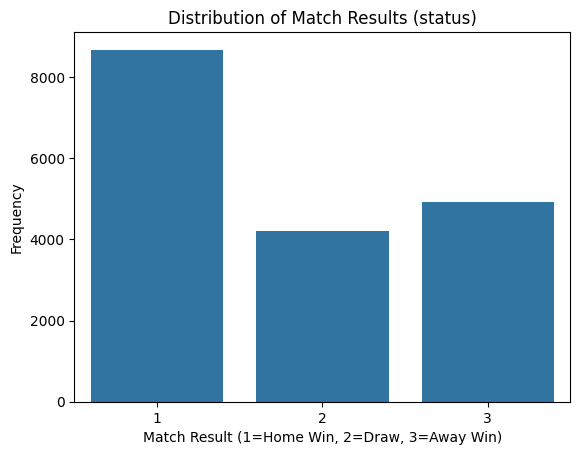

In [297]:
sns.countplot(x='status', data=df)
plt.title("Distribution of Match Results (status)")
plt.xlabel("Match Result (1=Home Win, 2=Draw, 3=Away Win)")
plt.ylabel("Frequency")
plt.show()

### Drop Leakage columns

Comparing the "home_goals" and "away_goals" directly give the outcome of the match. So we drop these two columns to avoid data leakage:

In [298]:
df = df.drop(columns=['home_goals', 'away_goals'])

### Correlation Matrix

We plot the correlation Matrix between numerical features and "Status" column. Many relations can be seen in the below heatmap. We can see that features like dif_inter_match, dif_inter_match_won and ... are highly correlated together. There is another highly correlated group of features which contains dif_wc_match, dif_wc_match_won and ...

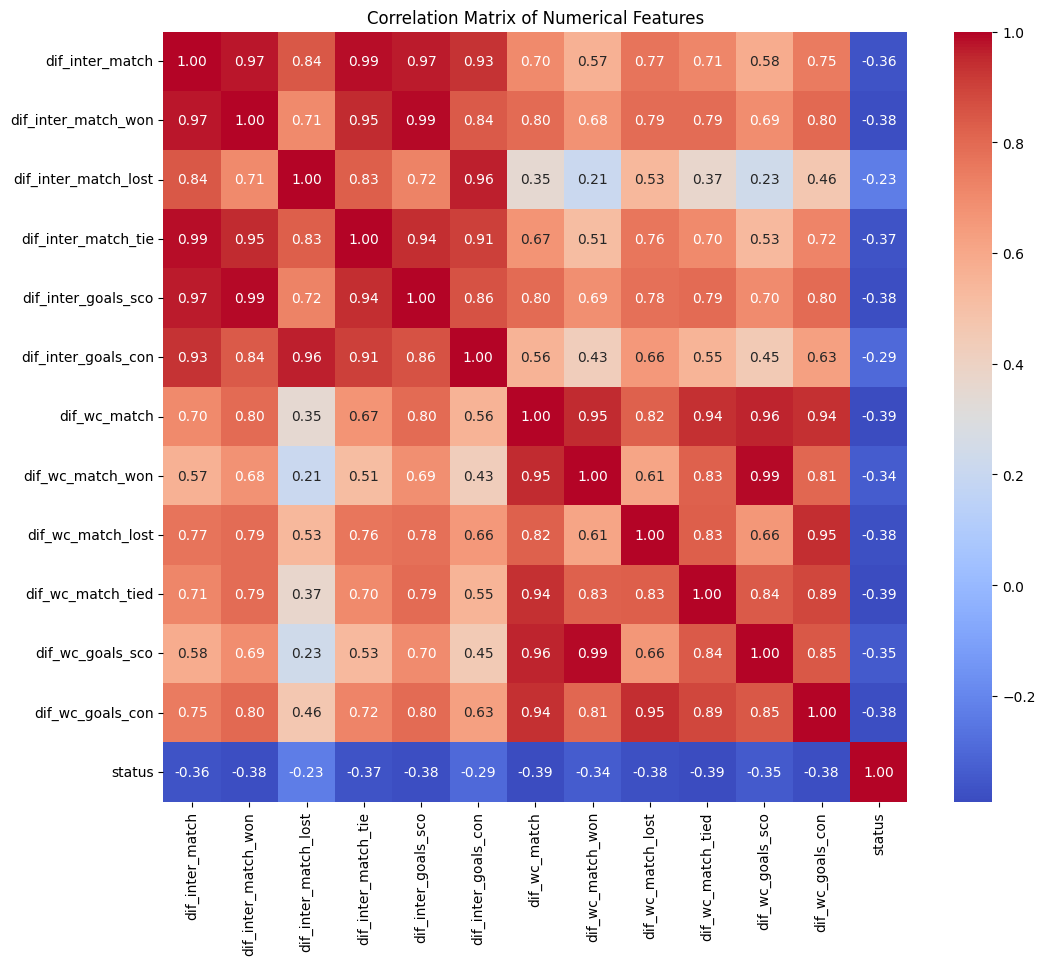

In [299]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['wcm'])
corr_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### Numerical Features Distribution

We can see that most of the features have bimodal distribution. But some of them like dif_wc_match_won are more similar to normal distribution:

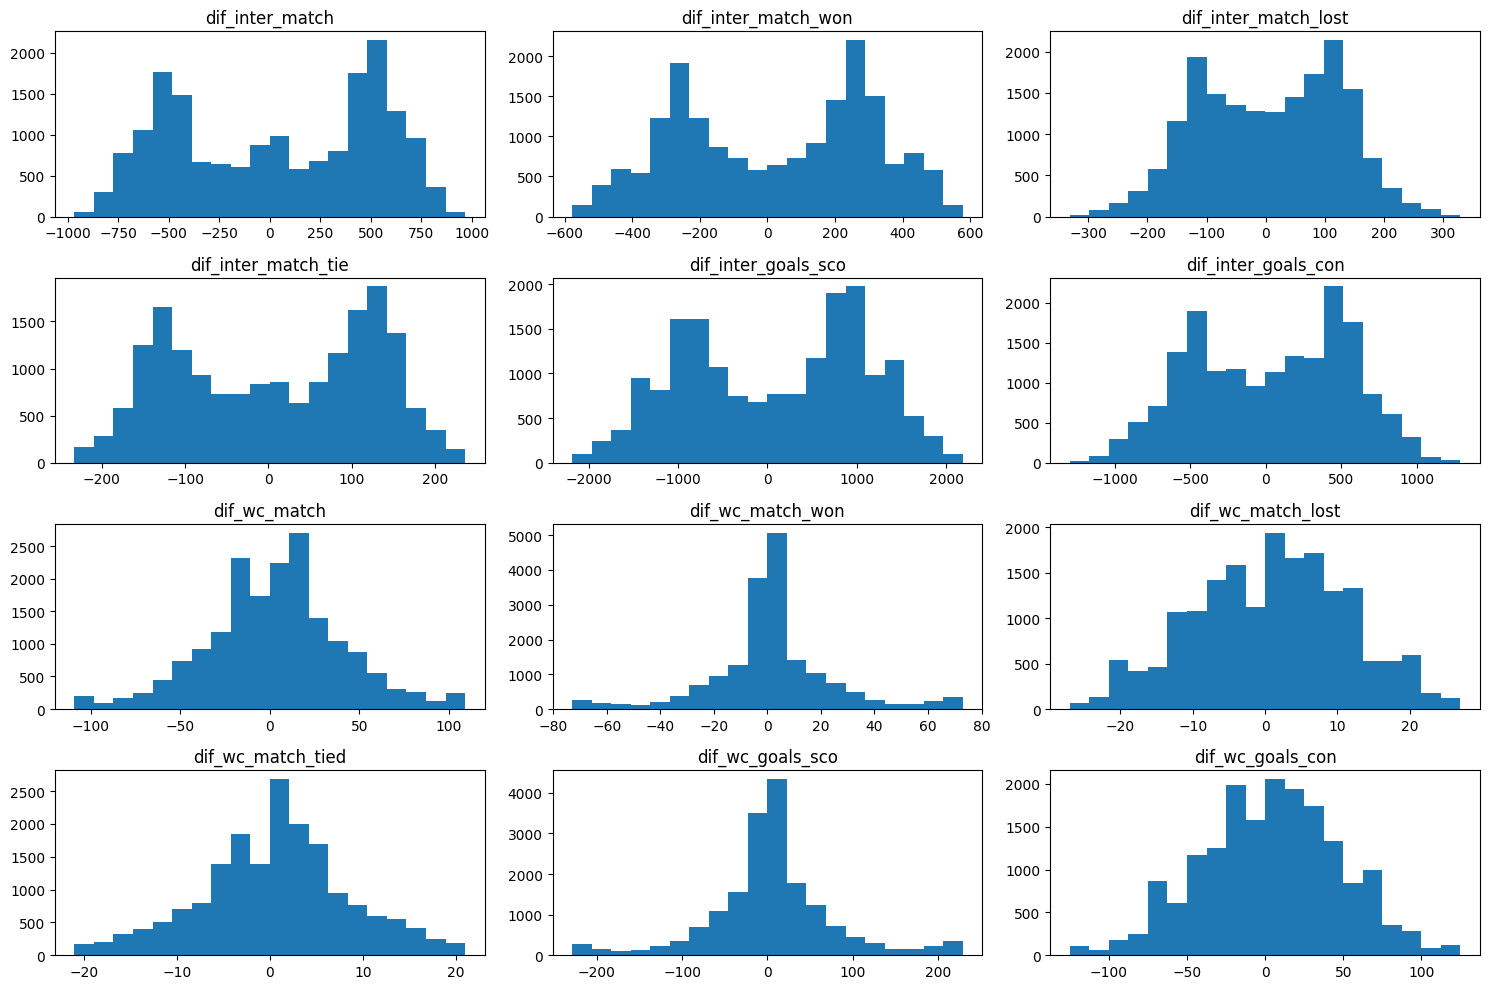

In [300]:
numerical_cols = numerical_cols.drop(columns="status")
axes = numerical_cols.hist(figsize=(15, 10), bins=20)
for ax in axes.flatten():
    ax.grid(False)
plt.tight_layout()
plt.show()

### Home VS Away performance

Win rate is so much higher for Home team:

In [301]:
home_win_rate = df[df['status'] == 1].shape[0] / df.shape[0]
away_win_rate = df[df['status'] == 3].shape[0] / df.shape[0]
draw_rate = df[df['status'] == 2].shape[0] / df.shape[0]

print(f"Home Win Rate: {home_win_rate:.2f}")
print(f"Draw Rate: {draw_rate:.2f}")
print(f"Away Win Rate: {away_win_rate:.2f}")

Home Win Rate: 0.49
Draw Rate: 0.24
Away Win Rate: 0.28


### Scaling Numerical columns

MLPs are sensitive to the scale of input features. Features with larger ranges can dominate the learning process. Standardization or normalization helps faster convergence and better performance. Some features range from -100 to +100, others from -5 to +5
Some distributions are highly skewed or spread out. So standardization is recommended:

In [302]:
features_to_scale = numerical_cols.columns
scaler = StandardScaler()
# df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df

,home_team,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,Italy,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,Portugal,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17807,Russia,Croatia,1,-100.0,-90.0,9.0,-19.0,-265.0,-43.0,22.0,8.0,8.0,6.0,42.0,28.0,2
17808,France,Belgium,1,53.0,68.0,-28.0,13.0,78.0,-104.0,18.0,14.0,0.0,4.0,52.0,5.0,1
17809,Croatia,England,1,-647.0,-391.0,-115.0,-141.0,-1617.0,-619.0,-46.0,-18.0,-11.0,-17.0,-56.0,-38.0,1
17810,Belgium,England,1,-222.0,-231.0,77.0,-68.0,-829.0,205.0,-21.0,-9.0,0.0,-12.0,-23.0,8.0,1


## 3. Data Preparation 

Excluding world cup mathces:

In [303]:
train_df = df[df['wcm'] == 0].copy()
train_df.head()

,home_team,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,Italy,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,Portugal,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1


We define X and y:

In [304]:
X = train_df.drop(columns=['home_team', 'away_team', 'status', 'wcm'])
y = train_df['status']

In [305]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

Train & Test Split:

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Scaling by StandardScaler:

In [307]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)    
X_test_scaled = scaler.transform(X_test)             

Converting to torch tensor:

In [308]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Wrapping in dataloader:

In [309]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## 4. Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2, activation='relu'):

        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        
        layers = []

        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(self._get_activation(activation))
        layers.append(nn.Dropout(dropout_rate))

        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
    
    def _get_activation(self, activation):
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU()
        }
        
        return activations.get(activation.lower(), nn.ReLU())
    
    def forward(self, X):
        return self.network(X)

## 5. Model Training

In [311]:
import torch.optim as optim

model = MLP(
        input_size = X_train_tensor.shape[1],  
        hidden_sizes = [512, 256, 128], 
        output_size = 3,  
        dropout_rate = 0.3,
        activation = 'relu'
    )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [312]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    
    train_acc = calculate_accuracy(model, train_loader)
    test_acc = calculate_accuracy(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/50, Loss: 0.9701, Train Acc: 0.5592, Test Acc: 0.5589
Epoch 2/50, Loss: 0.9624, Train Acc: 0.5596, Test Acc: 0.5581
Epoch 3/50, Loss: 0.9579, Train Acc: 0.5629, Test Acc: 0.5656
Epoch 4/50, Loss: 0.9558, Train Acc: 0.5634, Test Acc: 0.5637
Epoch 5/50, Loss: 0.9552, Train Acc: 0.5604, Test Acc: 0.5617
Epoch 6/50, Loss: 0.9554, Train Acc: 0.5607, Test Acc: 0.5621
Epoch 7/50, Loss: 0.9529, Train Acc: 0.5646, Test Acc: 0.5648
Epoch 8/50, Loss: 0.9514, Train Acc: 0.5649, Test Acc: 0.5662
Epoch 9/50, Loss: 0.9477, Train Acc: 0.5656, Test Acc: 0.5615
Epoch 10/50, Loss: 0.9488, Train Acc: 0.5652, Test Acc: 0.5676
Epoch 11/50, Loss: 0.9472, Train Acc: 0.5683, Test Acc: 0.5684
Epoch 12/50, Loss: 0.9470, Train Acc: 0.5672, Test Acc: 0.5690
Epoch 13/50, Loss: 0.9474, Train Acc: 0.5657, Test Acc: 0.5631
Epoch 14/50, Loss: 0.9456, Train Acc: 0.5688, Test Acc: 0.5686
Epoch 15/50, Loss: 0.9441, Train Acc: 0.5691, Test Acc: 0.5662
Epoch 16/50, Loss: 0.9450, Train Acc: 0.5707, Test Acc: 0.5633
E

## 6. Evaluating Model

In [313]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [314]:
final_accuracy = evaluate_model(model, test_loader)

Final Test Accuracy: 56.11%


## 7. World Cup!

In [396]:
wc_matches = df[df['wcm'] == 1].copy()
selected_columns = wc_matches.drop(columns=['home_team', 'away_team', 'status', 'wcm']).columns

X_wc = wc_matches.drop(columns=['home_team', 'away_team', 'status'])
X_wc_scaled = scaler.transform(X_wc[selected_columns])
X_wc_tensor = torch.tensor(X_wc_scaled, dtype=torch.float32)

In [397]:
model.eval()
with torch.no_grad():
    outputs = model(X_wc_tensor)
    _, predicted_classes = torch.max(outputs, 1)

wc_matches['predicted_status'] = predicted_classes.numpy()

### Evaluating Prediction

In [398]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = wc_matches['status'].values - 1 
y_pred = predicted_classes.numpy()

acc = accuracy_score(y_true, y_pred)
print(f"World Cup match prediction accuracy: {acc * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Home Win", "Tie", "Away Win"]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

World Cup match prediction accuracy: 55.44%
Classification Report:
              precision    recall  f1-score   support

    Home Win       0.61      0.81      0.70       503
         Tie       0.29      0.05      0.09       199
    Away Win       0.41      0.42      0.41       198

    accuracy                           0.55       900
   macro avg       0.44      0.43      0.40       900
weighted avg       0.50      0.55      0.50       900

Confusion Matrix:
[[406  15  82]
 [150  10  39]
 [105  10  83]]


### Groups

In [399]:
groups = {
    'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
    'B': ['England', 'Iran', 'USA', 'Wales'],
    'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
    'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
    'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
    'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
    'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
    'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
}

In [406]:
from collections import defaultdict
import random

wc_matches['predicted_status'] = predicted_classes.numpy() + 1  
group_points = defaultdict(lambda: {'points': 0, 'gd': 0, 'team': ''})

for group_name, teams in groups.items():
    for i in range(4):
        for j in range(i + 1, 4):
            team1 = teams[i]
            team2 = teams[j]

            match = wc_matches[
                ((wc_matches['home_team'] == team1) & (wc_matches['away_team'] == team2)) |
                ((wc_matches['home_team'] == team2) & (wc_matches['away_team'] == team1))
            ]

            if not match.empty:
                row = match.iloc[0]
                status = row['predicted_status']
                home = row['home_team']
                away = row['away_team']

                if status == 1:
                    group_points[home]['points'] += 3
                elif status == 2:
                    group_points[home]['points'] += 1
                    group_points[away]['points'] += 1
                elif status == 3:
                    group_points[away]['points'] += 3
            else:
                winner = random.choice([team1, team2])
                group_points[winner]['points'] += 3

            group_points[team1]['team'] = team1
            group_points[team2]['team'] = team2

In [407]:
qualified = []

for group_name, teams in groups.items():
    standings = sorted([group_points[t] for t in teams], key=lambda x: (-x['points'], -x['gd']))
    qualified += [standings[0]['team'], standings[1]['team']]

print("Qualified teams from group stage:")
display(qualified)

Qualified teams from group stage:


['Qatar',
 'Netherlands',
 'USA',
 'Wales',
 'Argentina',
 'Mexico',
 'France',
 'Denmark',
 'Spain',
 'Germany',
 'Belgium',
 'Morocco',
 'Brazil',
 'Serbia',
 'Uruguay',
 'Portugal']

### 1/16 Match-ups

In [408]:
round16 = [
    (qualified[0], qualified[3]), (qualified[2], qualified[1]),
    (qualified[4], qualified[7]), (qualified[6], qualified[5]),
    (qualified[8], qualified[11]), (qualified[10], qualified[9]),
    (qualified[12], qualified[15]), (qualified[14], qualified[13])
]

In [409]:
def simulate_match(team1, team2):
    match = wc_matches[
        ((wc_matches['home_team'] == team1) & (wc_matches['away_team'] == team2)) |
        ((wc_matches['home_team'] == team2) & (wc_matches['away_team'] == team1))
    ]

    if not match.empty:
        row = match.iloc[0]
        status = row['predicted_status']
        if (row['home_team'] == team1 and status == 1) or (row['away_team'] == team1 and status == 3):
            return team1
        elif status == 2:
            return random.choice([team1, team2]) 
        else:
            return team2
    else:
        return random.choice([team1, team2]) 
    
def knockout_round(teams):
    winners = []
    for i in range(0, len(teams), 2):
        winner = simulate_match(teams[i], teams[i+1])
        winners.append(winner)
    return winners    

In [410]:
quarter_finalists = knockout_round([a for a, b in round16] + [b for a, b in round16])
semi_finalists = knockout_round(quarter_finalists)
finalists = knockout_round(semi_finalists)
champion = knockout_round(finalists)

### World Cup prediction

In [411]:
print("quarter finalists:", quarter_finalists)
print("semi_finalists", semi_finalists)
print("finalists:", finalists)
print("World Cup Champion Prediction:", champion)

quarter finalists: ['Qatar', 'Argentina', 'Spain', 'Brazil', 'Wales', 'Denmark', 'Germany', 'Serbia']
semi_finalists ['Argentina', 'Spain', 'Denmark', 'Germany']
finalists: ['Argentina', 'Germany']
World Cup Champion Prediction: ['Argentina']
